In [2]:
# imports
from matplotlib import pyplot as plt
import pandas as pd
from hmmlearn import hmm
import numpy as np
import sys
import time
sys.path.insert(1, '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/')


import cleaner
import filter
from kalman import KalmanFilter

wsl = True

The following tables and images are from https://www.kaggle.com/code/jefmenegazzo/road-surface-type-classification

| Hardware       | Sensor         | Data                                 | Sampling Rate |
|----------------|----------------|--------------------------------------|---------------|
| HP Webcam HD-4110 | Camera      | 720p Video                           | 30 Hz         |
| Xiaomi Mi 8       | GPS         | Speed in m/s, latitude, longitude, etc. | 1 Hz       |
| MPU-9250          | Accelerometer | 3-axis acceleration in m/s²         | 100 Hz        |
| MPU-9250          | Gyroscope    | 3-axis rotation rate in deg/s        | 100 Hz        |
| MPU-9250          | Magnetometer | 3-axis ambient geomagnetic field in µT | 100 Hz       |
| MPU-9250          | Temperature  | Sensor temperature in ◦C              | 100 Hz       |

| DataSet | Vehicle              | Driver   | Scenario  | Distance |
|---------|----------------------|----------|-----------|----------|
| PVS 1   | Volkswagen Saveiro   | Driver 1 | Scenario 1| 13.81 km |
| PVS 2   | Volkswagen Saveiro   | Driver 1 | Scenario 2| 11.62 km |
| PVS 3   | Volkswagen Saveiro   | Driver 1 | Scenario 3| 10.72 km |
| PVS 4   | Fiat Bravo           | Driver 2 | Scenario 1| 13.81 km |
| PVS 5   | Fiat Bravo           | Driver 2 | Scenario 2| 11.63 km |
| PVS 6   | Fiat Bravo           | Driver 2 | Scenario 3| 10.73 km |
| PVS 7   | Fiat Palio           | Driver 3 | Scenario 1| 13.78 km |
| PVS 8   | Fiat Palio           | Driver 3 | Scenario 2| 11.63 km |
| PVS 9   | Fiat Palio           | Driver 3 | Scenario 3| 10.74 km |

| File                   | Description                                                                                       |
|------------------------|---------------------------------------------------------------------------------------------------|
| dataset_gps.csv        | GPS data, including latitude, longitude, altitude, speed, accuracy, etc.                         |
| dataset_gps_mpu_left.csv  | Inertial sensor data on the left side of the vehicle, combined with GPS data.                     |
| dataset_gps_mpu_right.csv | Inertial sensor data on the right side of the vehicle, combined with GPS data.                    |
| dataset_labels.csv       | Data classes for each sample data in the dataset (for both sides).                                  |
| dataset_mpu_left.csv     | Inertial sensor data on the left side of the vehicle.                                              |
| dataset_mpu_right.csv    | Inertial sensor data on the right side of the vehicle.                                             |

![Map of paths](./maps.png "All paths driven by the three drivers.")


In [4]:
if wsl:
    parent = '/mnt/c/Users/dalli/source/acme_senior/_projectV3/CarKalmanFilter/.data'
else:
    parent = ".data"
data_dict = cleaner.clean_dict(cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"]))

In [3]:
cleaner.print_structure(data_dict)


  train: 
 	 t_gps: 
 		 PVS 1: (1458, 11)
 		 PVS 2: (1551, 11)
 		 PVS 3: (1316, 11)
 		 PVS 4: (1432, 11)
 		 PVS 5: (1263, 11)
 		 PVS 6: (915, 11)
 	 gps_mpu_left: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 	 gps_mpu_right: 
 		 PVS 1: (144036, 26)
 		 PVS 2: (124684, 26)
 		 PVS 3: (105816, 26)
 		 PVS 4: (132492, 26)
 		 PVS 5: (133877, 26)
 		 PVS 6: (96279, 26)
 	 labels: 
 		 PVS 1: (144036, 14)
 		 PVS 2: (124684, 14)
 		 PVS 3: (105816, 14)
 		 PVS 4: (132492, 14)
 		 PVS 5: (133877, 14)
 		 PVS 6: (96279, 14)
 	 folders: 6
  val: 
 	 t_gps: 
 		 PVS 9: (999, 11)
 	 gps_mpu_left: 
 		 PVS 9: (91555, 26)
 	 gps_mpu_right: 
 		 PVS 9: (91555, 26)
 	 labels: 
 		 PVS 9: (91555, 14)
 	 folders: 1
  test: 
 	 t_gps: 
 		 PVS 7: (1281, 11)
 		 PVS 8: (1134, 11)
 	 gps_mpu_left: 
 		 PVS 7: (128548, 26)
 		 PVS 8: (123618, 26)
 	 gps_mpu_right: 
 		 PVS 7: (128548, 26)
 		 PVS 8:

In [ ]:
filter.add_smoothed_cols(data_dict, window=200)

In [ ]:
filter.add_diff_cols(data_dict)

In [6]:
len(data_dict["train"]["t_gps"]["PVS 1"])

1458

In [23]:
def build_z_dash(df, type="train", road="good_road_left"):
    """
    Builds a 1 column dataset from the given dictionary of dataframes
    timestamp
    latitude
    longitude
    elevation
    acc_x_dash_smooth
    acc_y_dash_smooth
    acc_z_dash_smooth

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = None
    lengths = []
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder]
        labels = df[type]["labels"][folder][road]
        indices = labels[labels == 1].index

        new_data = pvsi.loc[indices]["acc_z_dash_smooth"]
        lengths.append(len(new_data))

        if result is None:
            result = new_data
        else:
            # append on the same column
            result = pd.concat([result, new_data], axis=0)
    return result, lengths
    


def build_gps_data(df, type="train"):
    """
    Builds a 6 column dataset from the given dataframe

    :param df: dataframe
    :param type: string

    :return: dataframe with only the acc_z_dash column
    :return: list of lengths
    """
    result = {}
    for folder in df[type]["gps_mpu_left"].keys():
        pvsi = df[type]["gps_mpu_left"][folder][["timestamp", "meters_latitude", "meters_longitude", "acc_x_dash_smooth", "acc_y_dash_smooth", "acc_z_dash_smooth"]]
        elevation = df[type]["t_gps"][folder][["timestamp", "meters_elevation"]]

        # merge the two dataframes on timestamp then remove timestamp
        pvsi = pd.merge(pvsi, elevation, on="timestamp")
        pvsi = pvsi.drop(columns=["timestamp"])

        result[folder] = pvsi
    return result


train_dict = {
    "good": build_z_dash(data_dict, type="train", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="train", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="train", road="bad_road_left")
}

test_dict = {
    "good": build_z_dash(data_dict, type="test", road="good_road_left"),
    "regular": build_z_dash(data_dict, type="test", road="regular_road_left"),
    "bad": build_z_dash(data_dict, type="test", road="bad_road_left")
}

kal_data = build_gps_data(data_dict, type="train")

In [15]:
kal_data["PVS 1"]["meters_latitude"].shape

(1024,)

# Kalman Filter

In [8]:
from geopy.distance import geodesic


# select data
data = cleaner.load_data(parent, exclude_test=["PVS 7", "PVS 8"], exclude_val=["PVS 9"])
df = data['train']['gps_mpu_left']['PVS 1']

# average acceleration 
acc_x_cols = ['acc_x_dashboard', 'acc_x_above_suspension', 'acc_x_below_suspension']
acc_y_cols = ['acc_y_dashboard', 'acc_y_above_suspension', 'acc_y_below_suspension']
acc_z_cols = ['acc_z_dashboard', 'acc_z_above_suspension', 'acc_z_below_suspension']

df['acc_x'] = df[acc_x_cols].mean(axis=1)
df['acc_y'] = df[acc_y_cols].mean(axis=1)
df['acc_z'] = df[acc_z_cols].mean(axis=1)

# normalize z acc
df['acc_z'] = df['acc_z'] - df['acc_z'].mean()

# merge elevation data in 
cols = ['latitude', 'longitude', 'acc_x', 'acc_y', 'acc_z']
df = data['train']['gps_mpu_left']['PVS 1'][cols].merge(data['train']['t_gps']['PVS 1'][['latitude', 'longitude', 'elevation']], 'left', on=['latitude', 'longitude'])

# convert the coordinates to meters 
reference_point = (df['latitude'].iloc[0], df['longitude'].iloc[0])
x_diffs = [geodesic((df['latitude'].iloc[0], df['longitude'].iloc[i]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
x_diffs.append(None)

y_diffs = [geodesic((df['latitude'].iloc[i], df['longitude'].iloc[0]), (df['latitude'].iloc[i], df['longitude'].iloc[i])).meters for i in range(len(df)-1)]
y_diffs.append(None)

# add to dataframe
df['lat_m'] = x_diffs
df['long_m'] = y_diffs
df.dropna(inplace=True)


In [83]:
Q = np.eye(9) * 0.1
R = np.eye(6) * 1000
dt = .1
F = np.array(  [[1,0,0,dt,0,0,0,0,0],
                [0,1,0,0,dt,0,0,0,0],
                [0,0,1,0,0,dt,0,0,0],
                [0,0,0,1,0,0,dt,0,0],
                [0,0,0,0,1,0,0,dt,0],
                [0,0,0,0,0,1,0,0,dt],
                [0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,1]])
G = np.ones((9,9))

# initial state
x0 = np.zeros(9)
P0 = 1e5 * Q
z = df[['lat_m', 'long_m', 'elevation', 'acc_x', 'acc_y', 'acc_z']].to_numpy().T
tsteps = 1000

H = np.zeros((6, 9))
for i in range(3):
    H[i, i] = 1
    H[i + 3, i + 6] = 1
# control u
u = np.zeros(9)

kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

In [84]:
def plot_subplots(array1, array2, start, n, title):
    num_subplots = 20
    num_points = len(array1)
    num_plots = num_points // n
    t_start = start // 1000

    fig, axs = plt.subplots(num_subplots // 5, 5, figsize=(15, 10))

    for i in range(num_subplots):
        if i < num_plots:
            start_index = i * n + start
            end_index = min((i + 1) * n, num_points) + start
            points1 = array1[start_index:end_index]
            points2 = array2[start_index:end_index]
            ax = axs[i // 5, i % 5]
            ax.scatter(range(len(points2)), points2, alpha=0.5, s=1, color="blue")
            ax.scatter(range(len(points1)), points1, color="red", s=1)
            ax.set_title(f"Time: {t_start + (i*n)/1000} s")
        else:
            fig.delaxes(axs[i // 5, i % 5])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # plot the original data
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(range(len(array2)), array2)
    plt.plot(range(len(array1)), array1)
    plt.title("Original Data")
    plt.subplot(122)
    plt.plot(range(len(array1)), array1)
    plt.title("Estimated Data")
    plt.tight_layout()
    plt.show()

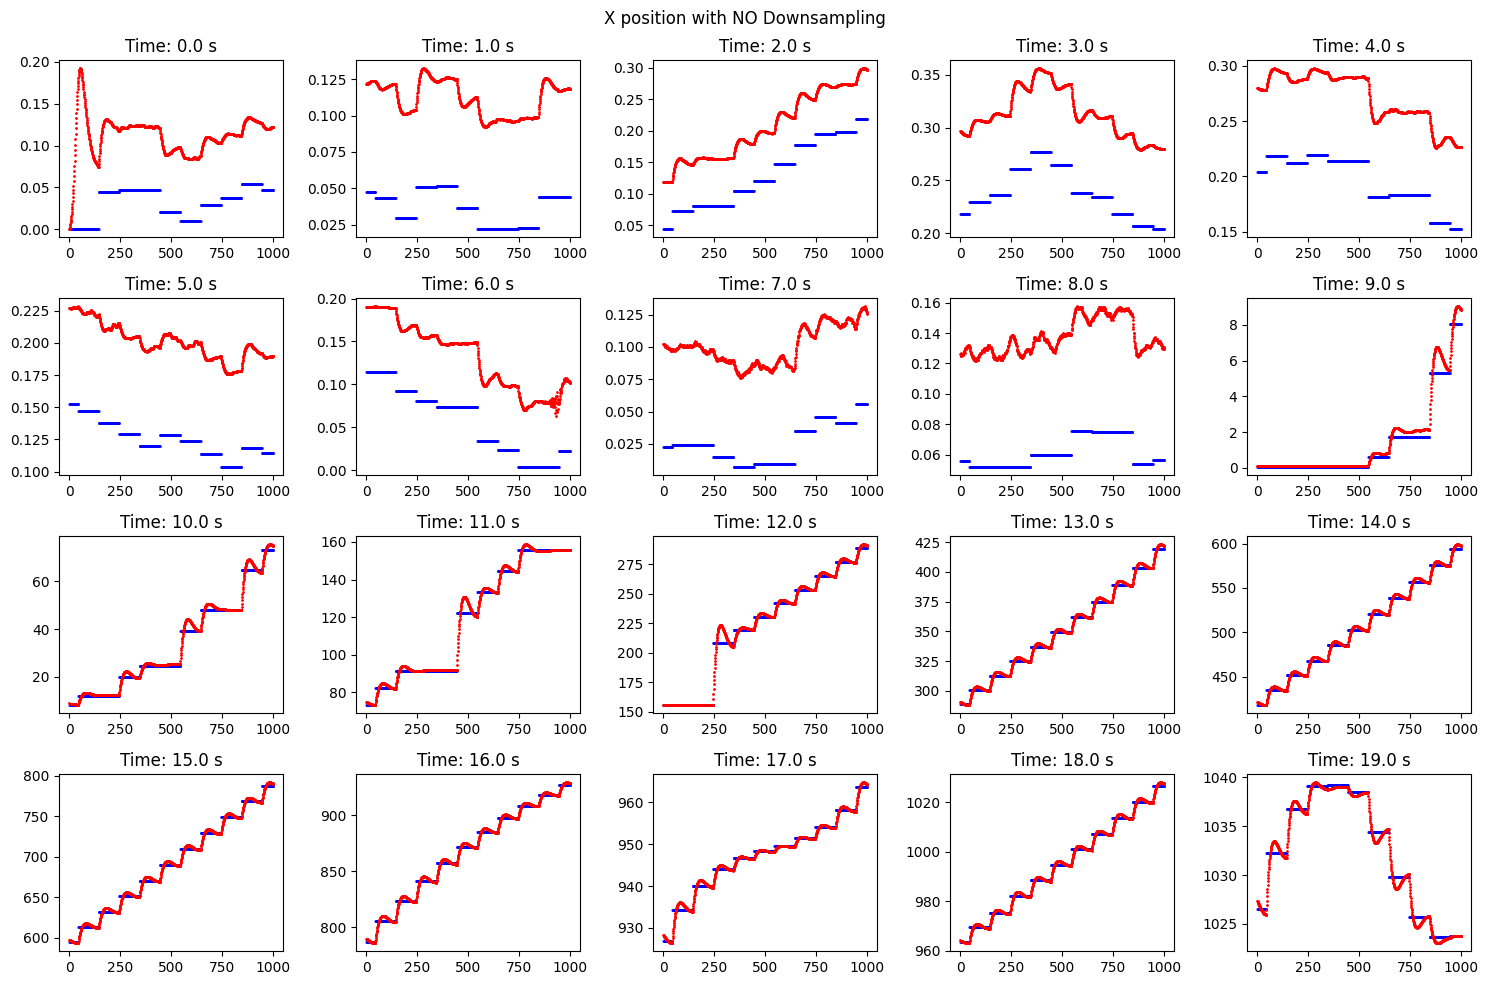

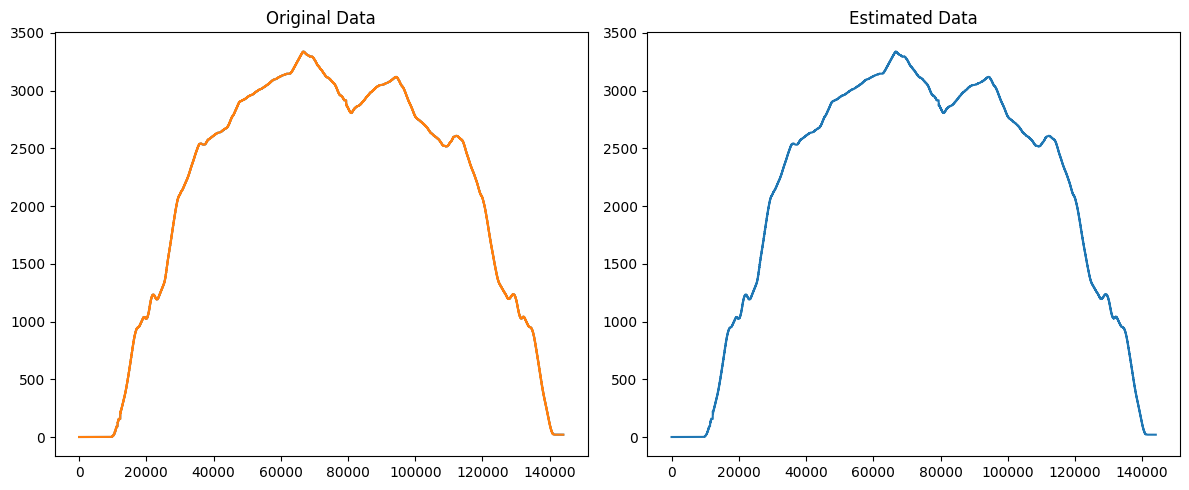

Average difference between estimated and actual x position:  1.0000815875693072


In [85]:
index = 1
offset = 0
z_index = index if index < 3 else index - 3
plot_subplots(est[index, offset:], z[z_index], 0, 1000, "X position with NO Downsampling")

# find the average difference between two arrays
def avg_diff(array1, array2):
    return np.mean(np.abs(array1 - array2))

print("Average difference between estimated and actual x position: ", avg_diff(est[index, offset:], z[z_index]))

In [86]:
# downsample z by a factor of 50
z = z[:,::10]
kf = KalmanFilter(F, Q, H, R, G, u)
est = kf.estimate(x0, P0, z)

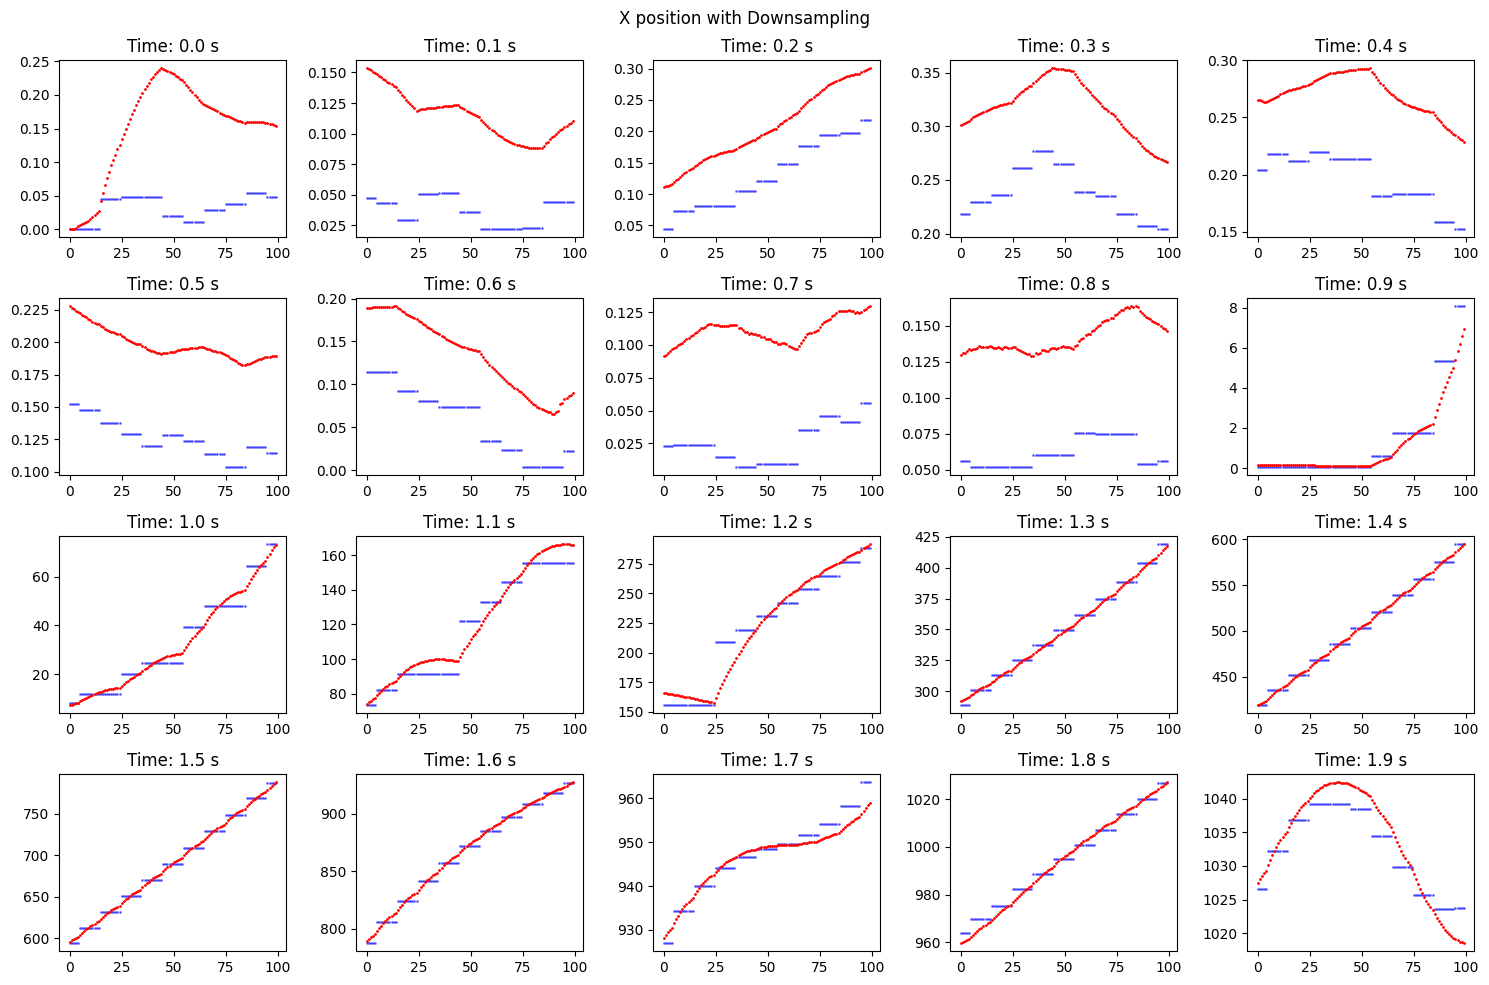

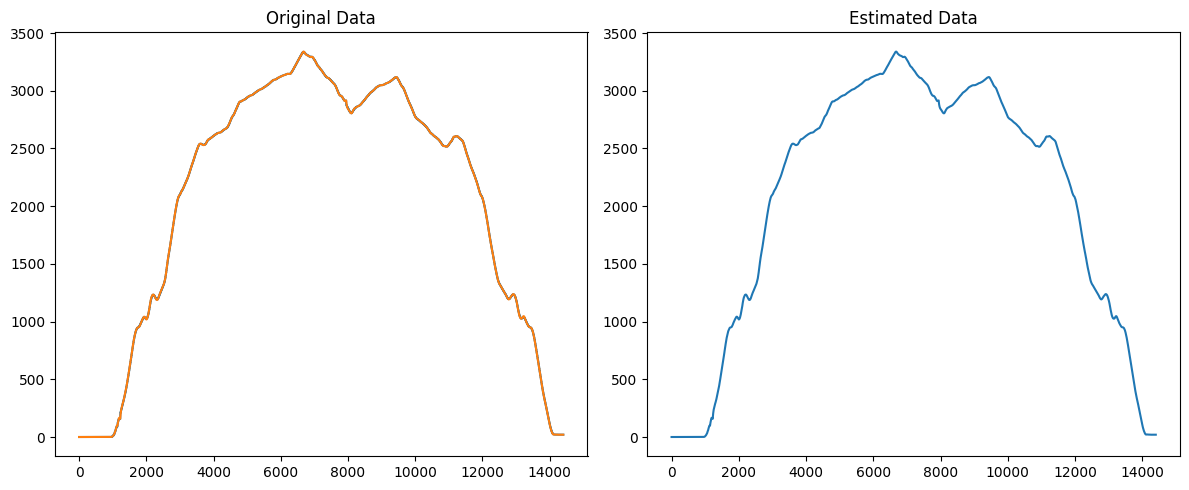

Average difference between estimated and actual x position:  1.7512151534409846


In [87]:
index = 1
offset = 0
z_index = index if index < 3 else index - 3
plot_subplots(est[index, offset:], z[z_index], 0, 100, "X position with Downsampling")

# find the average difference between two arrays
def avg_diff(array1, array2):
    return np.mean(np.abs(array1 - array2))

print("Average difference between estimated and actual x position: ", avg_diff(est[index, offset:], z[z_index]))

Red is the estimate, blue is the observations

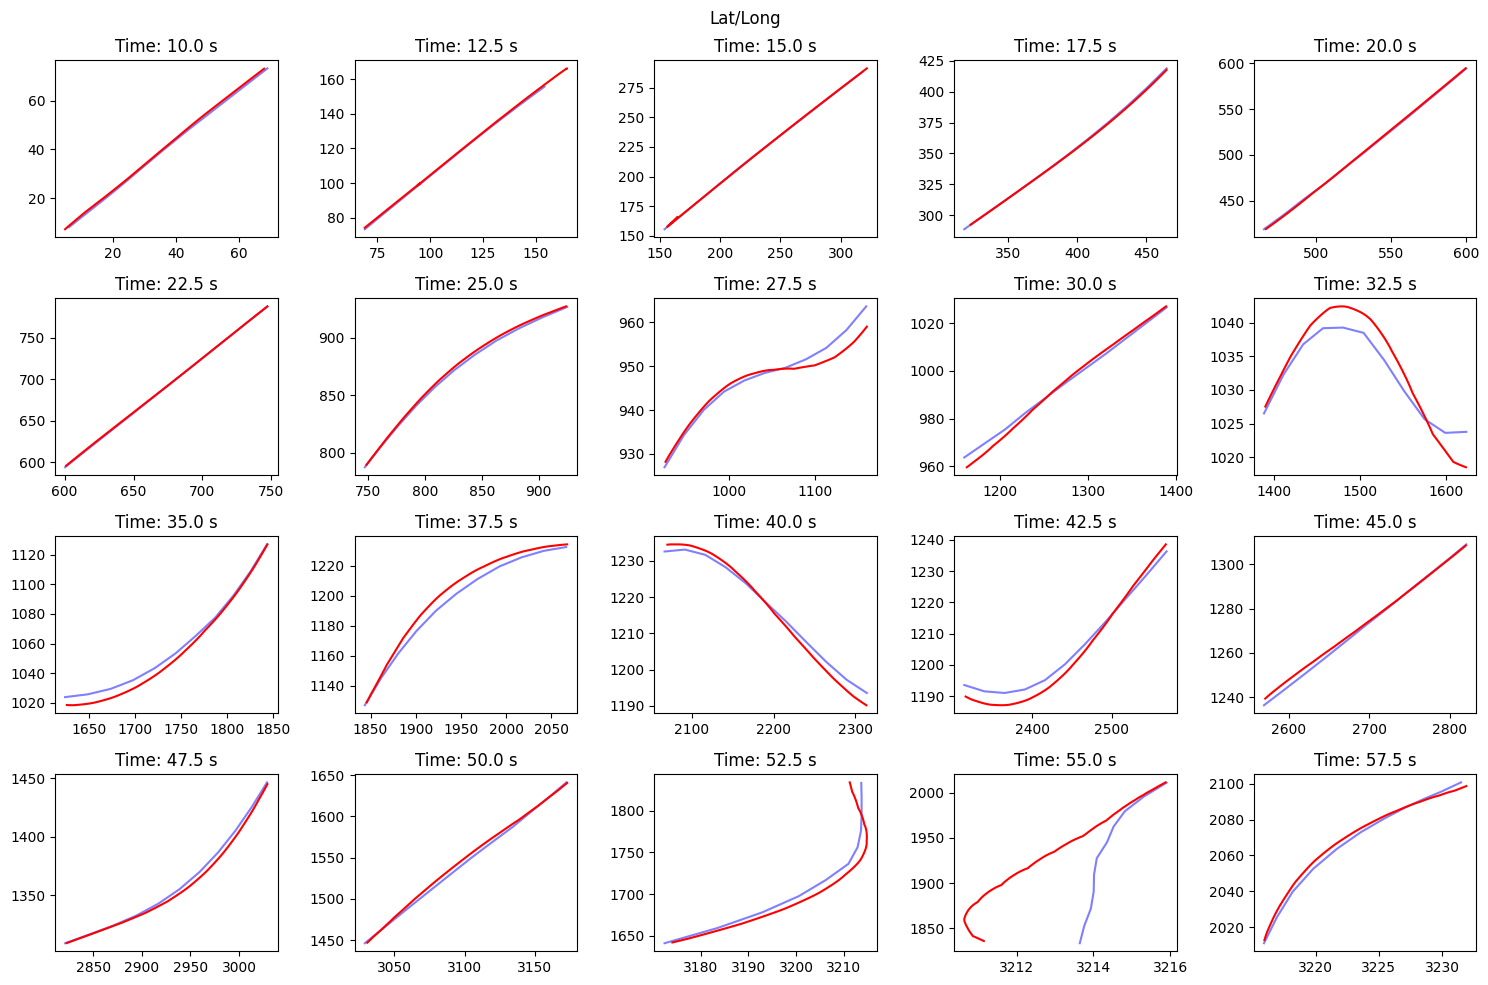

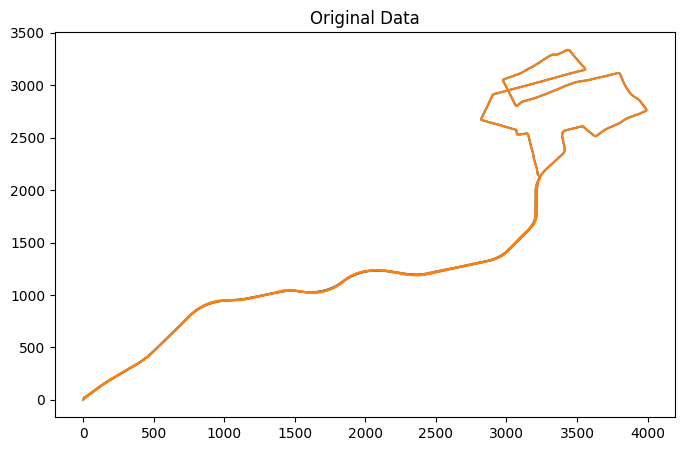

In [88]:
def scatter_subplots(x2, y2, x1, y1, start, n, title):
    num_subplots = 20
    num_points = len(x1)
    num_plots = num_points // n
    t_start = start // 100

    fig, axs = plt.subplots(num_subplots // 5, 5, figsize=(15, 10))

    for i in range(num_subplots):
        if i < num_plots:
            start_index = i * n + start
            end_index = min((i + 1) * n, num_points) + start
            _x1 = x1[start_index:end_index]
            _x2 = x2[start_index:end_index]
            _y1 = y1[start_index:end_index]
            _y2 = y2[start_index:end_index]
            ax = axs[i // 5, i % 5]
            ax.plot(_x1, _y1, alpha=0.5, color="blue")
            ax.plot(_x2, _y2, color="red")
            ax.set_title(f"Time: {t_start + (i*n)/40} s")
        else:
            fig.delaxes(axs[i // 5, i % 5])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # plot the original data
    plt.figure(figsize=(8, 5))
    plt.plot(x1, y1)
    plt.plot(x2, y2)
    plt.title("Original Data")
    plt.show()

index = 1
offset = 0
z_index = index if index < 3 else index - 3
scatter_subplots(est[0, offset:], est[1, offset:], z[0], z[1], 1000, 100, "Lat/Long")

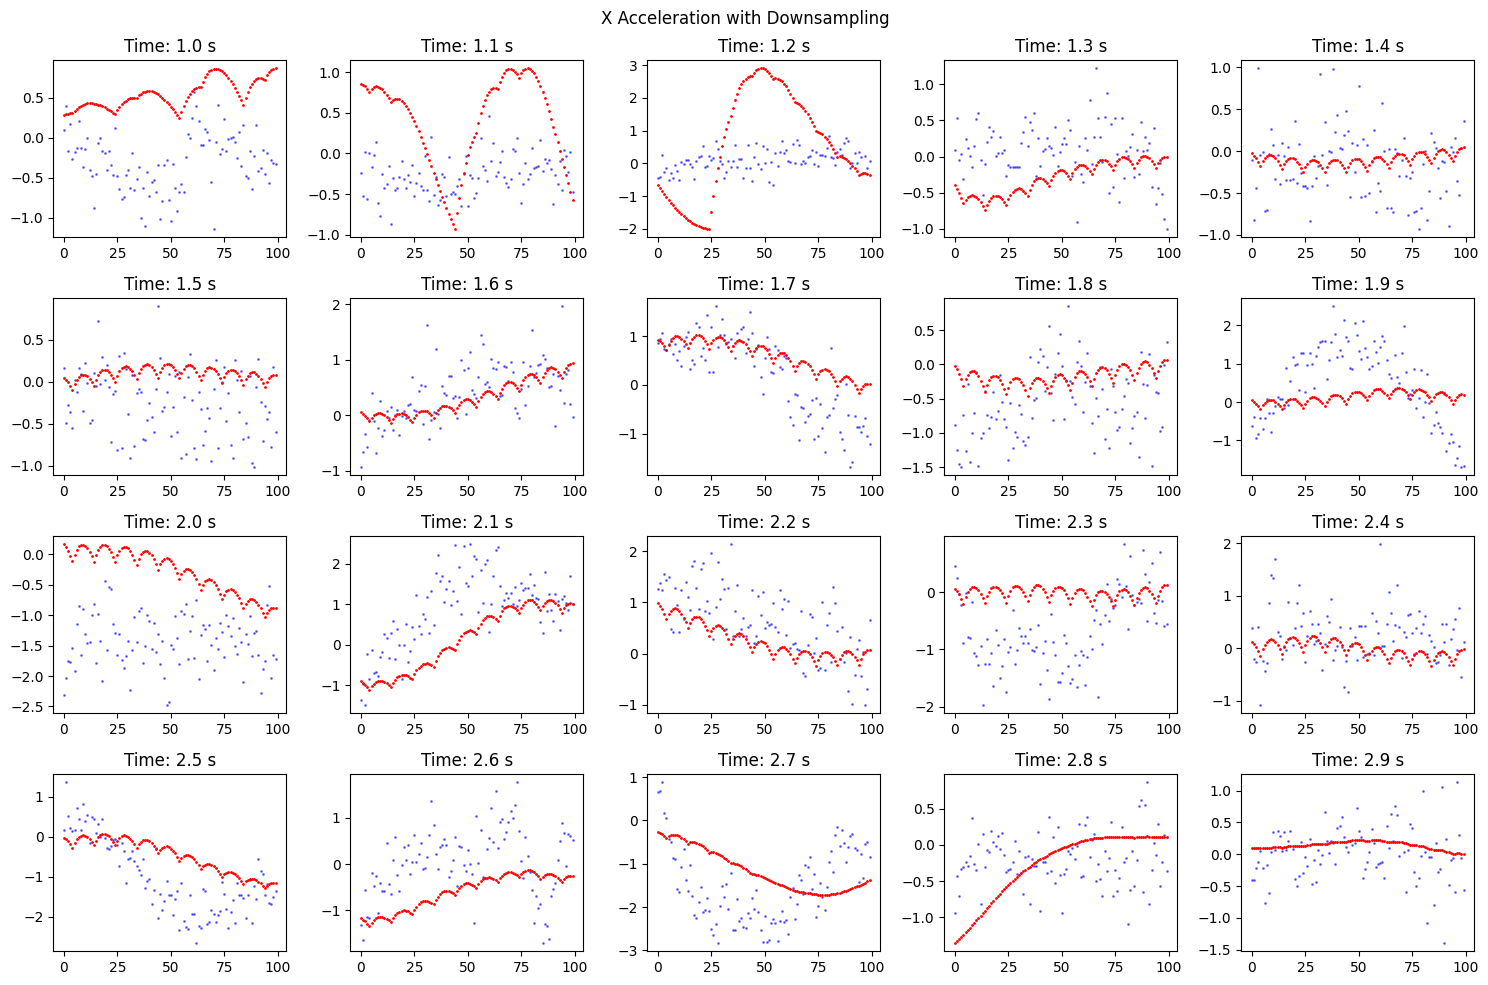

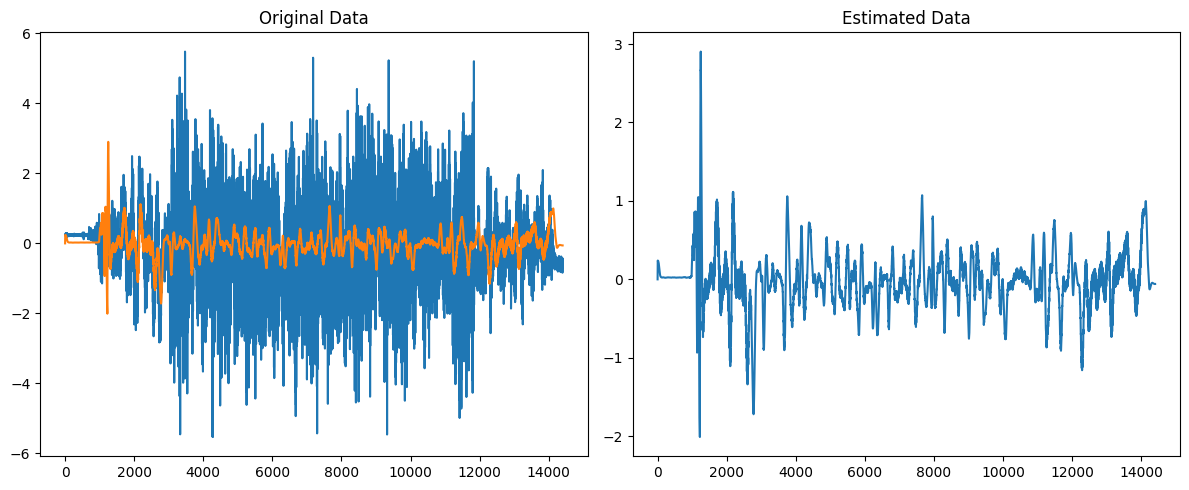

In [89]:
index = 6
offset = 0
z_index = index if index < 3 else index - 3
plot_subplots(est[index, offset:], z[z_index], 1000, 100, "X Acceleration with Downsampling")

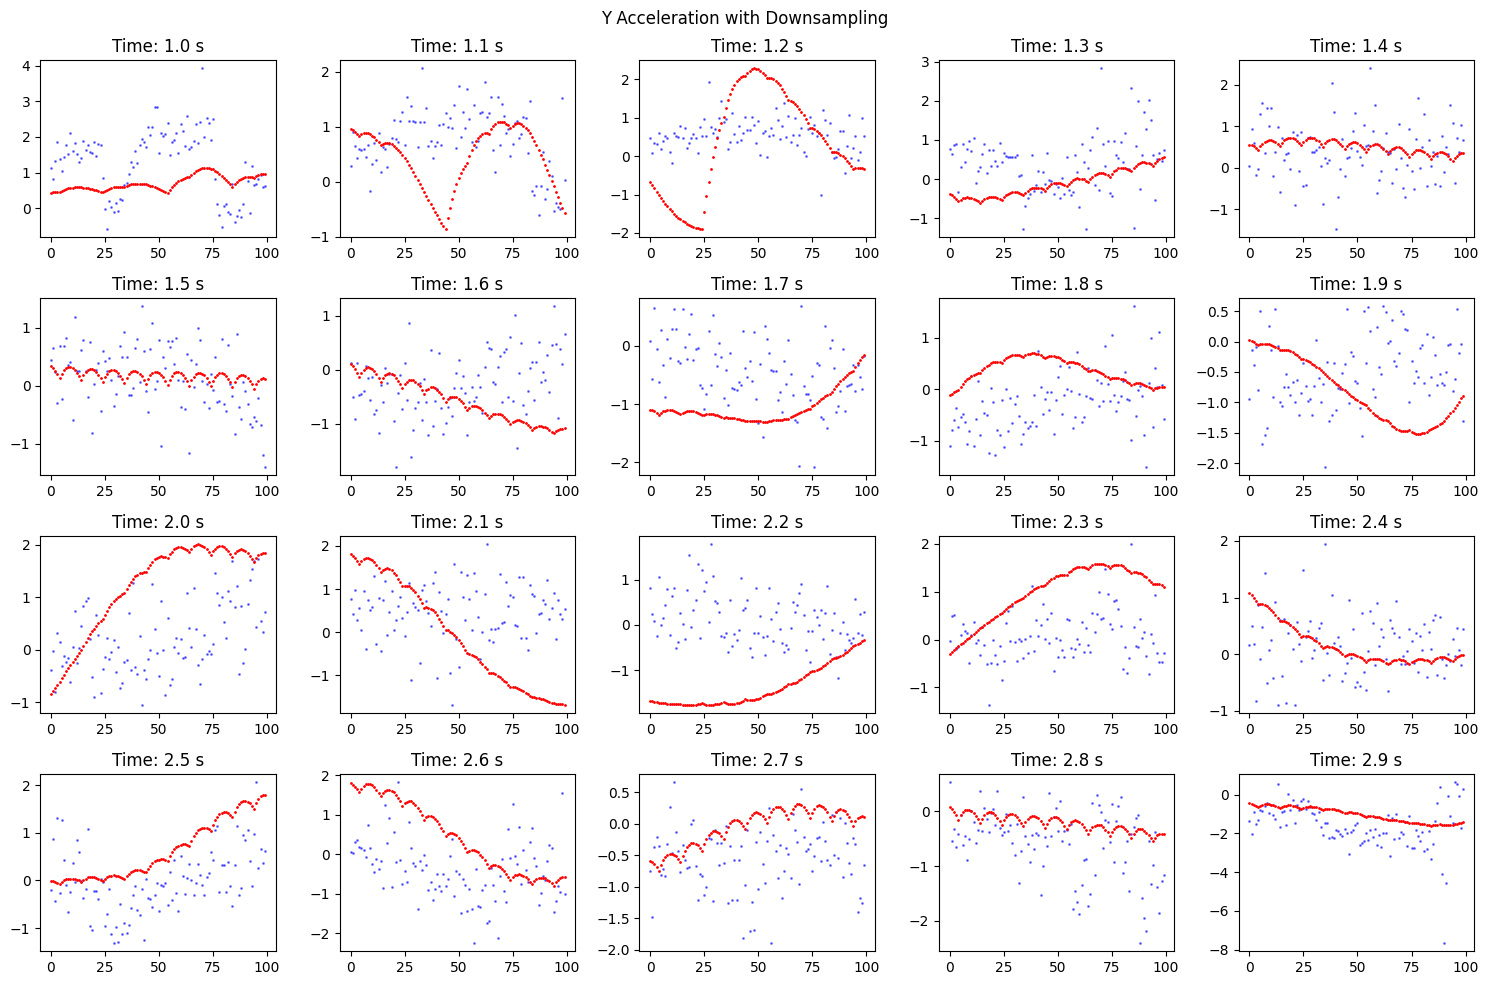

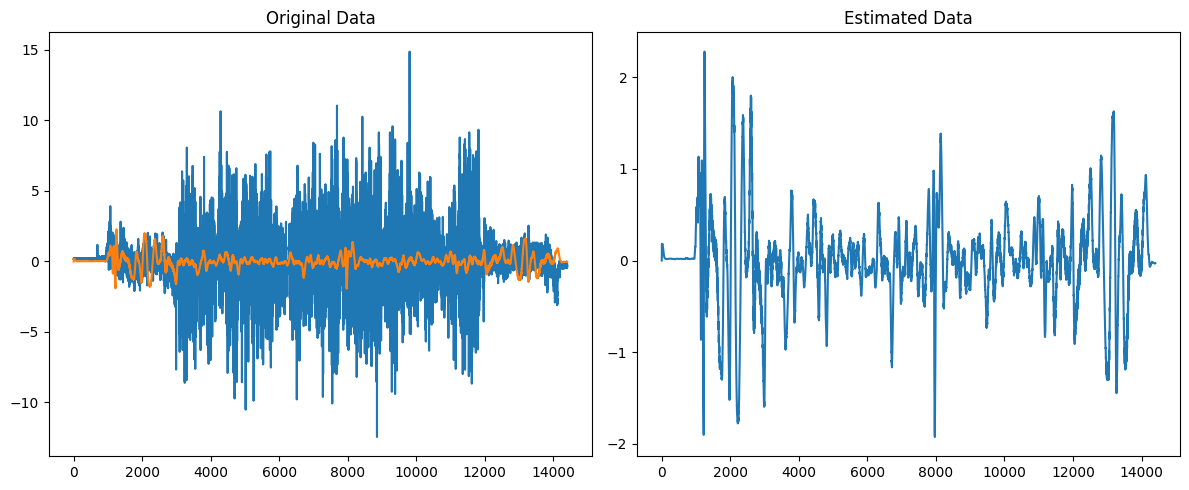

In [90]:
index = 7
offset = 0
z_index = index if index < 3 else index - 3
plot_subplots(est[index, offset:], z[z_index], 1000, 100, "Y Acceleration with Downsampling")

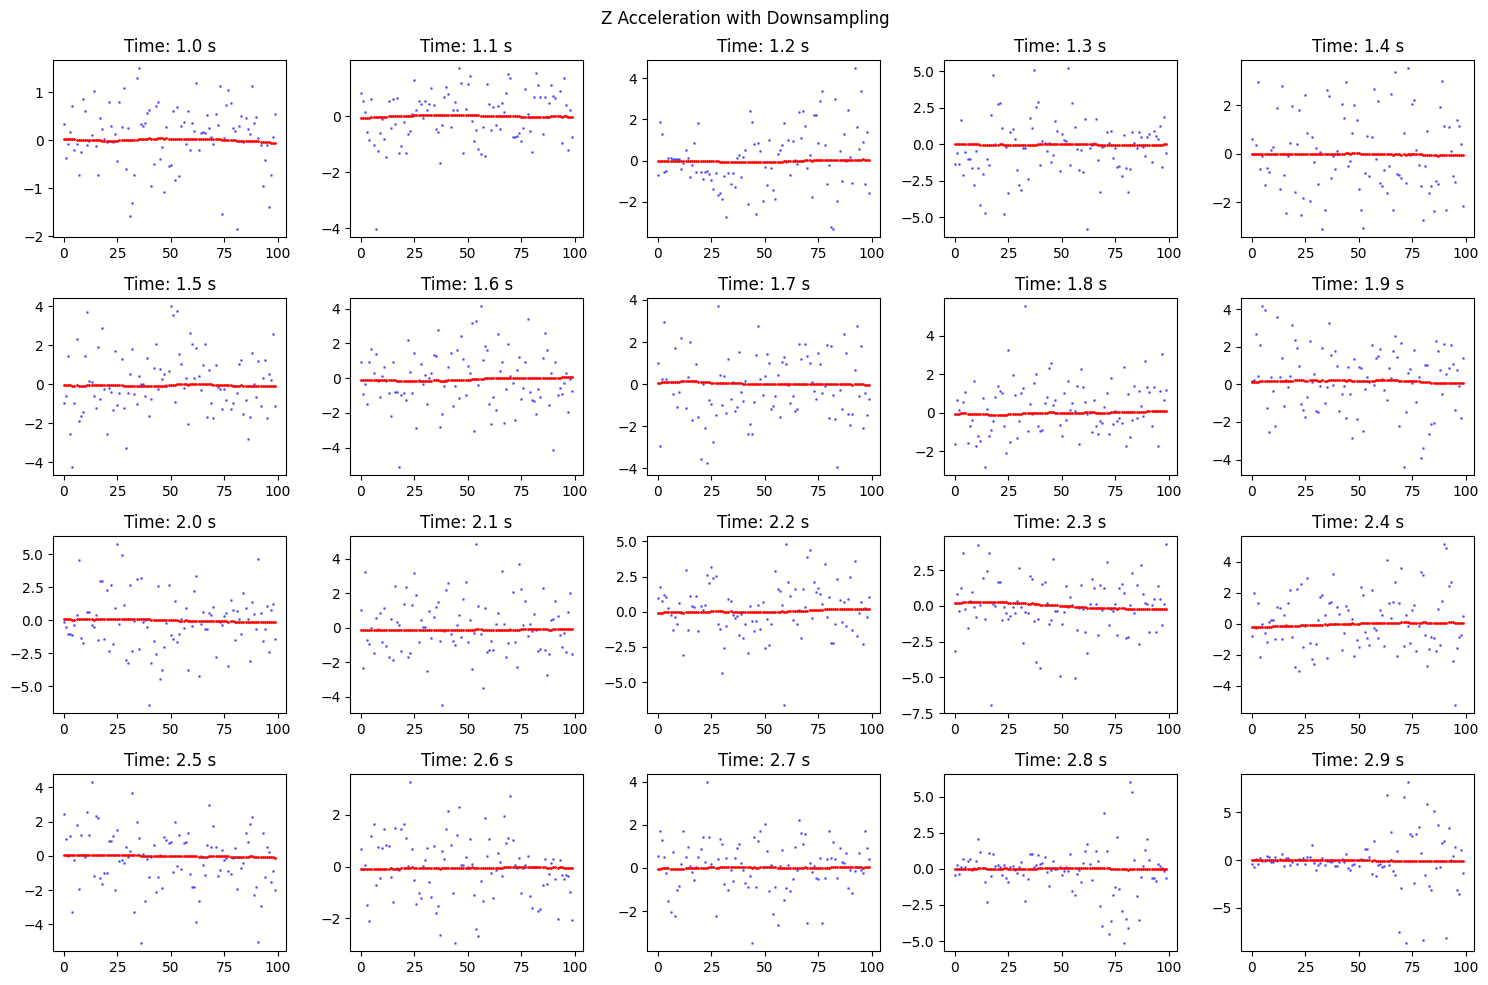

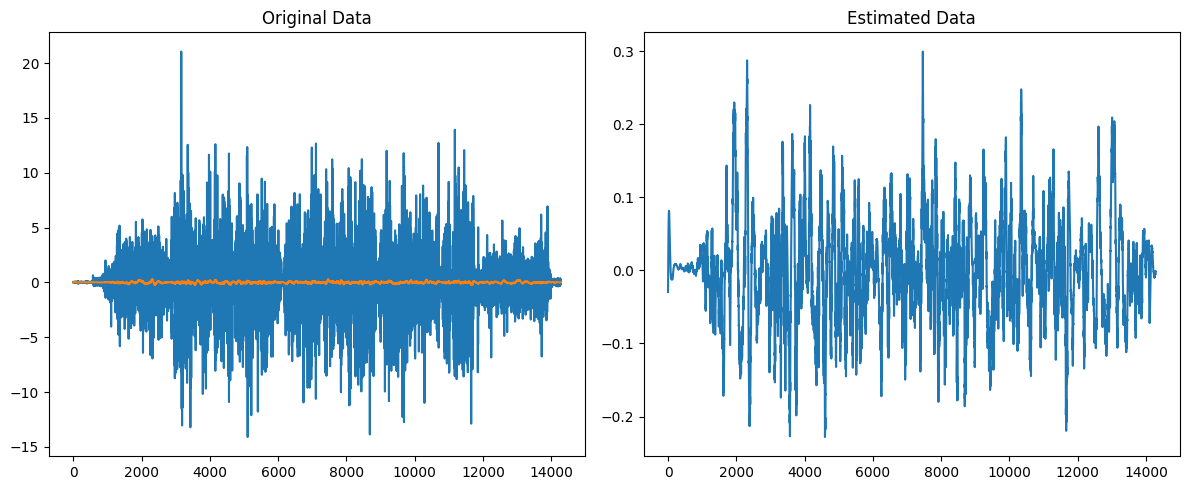

In [95]:
index = 8
offset = 120
z_index = index if index < 3 else index - 3
plot_subplots(est[index, offset:], z[z_index, offset:], 1000, 100, "Z Acceleration with Downsampling")

# HMM

I got it to run (it turns out that you can only include one series as your input data) but it doesn't work. I think the HMM decided that zeros are local minimums or values below a threshold and pretty much everything else is ones.

In [25]:
model_list = []
for nc in range(2, 10):
    print("\n{nc} components:")
    models = {}
    num_models = 3
    for key in train_dict.keys():
        # make data an array
        data, lengths = train_dict[key]
        data = data.values.reshape(-1, 1)
        print(key, end=": ")

        best_log = -np.inf
        best_model = None
        for i in range(num_models):
            # Initialize and train the model
            model = hmm.GMMHMM(n_components=nc, covariance_type="diag")
            model.fit(data, lengths=lengths)
            # Check the log-likelihood
            log_likelihood = model.monitor_.history[-1]
            if log_likelihood > best_log:
                best_log = log_likelihood
                best_model = model
            print(i, end=", ")
        models[key] = best_model
    
    model_list.append(models)

good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, good: 0, 1, 2, regular: 0, 1, 2, bad: 0, 1, 2, 

In [37]:
# predicted_labels = model.predict(X)

def predict(mfcc_coeffs, index):
    """
    Predict the word from the given mfcc coefficients
    
    Parameters
    ----------
    mfcc_coeffs : ndarray of shape (M,)
        The mfcc coefficients for the word to be predicted
    index : int
        The index of the model in the list of models
        
    Returns
    -------
    word : str
        The predicted word
    """
    # find the log probability density of the given mfcc coefficients
    log_prob = {}
    for key in model_list[index].keys():
        log_prob[key] = model_list[index][key].score(mfcc_coeffs)
    
    # return the word with the highest probability
    return max(log_prob, key=log_prob.get)



time_window = 10 # seconds
time_window *= 1000

for j, nc in enumerate(range(2, 10)):
    print("Number of components:", nc)
    for key in test_dict.keys():
        correct = 0
        incorrect = 0
        test_data, _ = test_dict[key]

        # iterate over test_data in groups of 10000
        test_data = test_data.values.reshape(-1, 1)
        for i in range(0, len(test_data), time_window):
            item = test_data[i:i+time_window]
            prediction = predict(item, j)
            if prediction == key:
                correct += 1
            elif prediction == "good" and key == "regular":
                correct += 1
            elif prediction == "regular" and key == "good":
                correct += 1
            else:
                incorrect += 1
        
        print("Accuracy for", key, ":", correct/(correct+incorrect))
    print()

Number of components: 2
Accuracy for good : 0.8181818181818182
Accuracy for regular : 0.9
Accuracy for bad : 0.0

Number of components: 3
Accuracy for good : 0.8181818181818182
Accuracy for regular : 1.0
Accuracy for bad : 0.0

Number of components: 4
Accuracy for good : 0.7272727272727273
Accuracy for regular : 1.0
Accuracy for bad : 0.0

Number of components: 5
Accuracy for good : 1.0
Accuracy for regular : 1.0
Accuracy for bad : 0.0

Number of components: 6
Accuracy for good : 0.7272727272727273
Accuracy for regular : 0.6
Accuracy for bad : 0.16666666666666666

Number of components: 7
Accuracy for good : 0.7272727272727273
Accuracy for regular : 0.4
Accuracy for bad : 0.5

Number of components: 8
Accuracy for good : 1.0
Accuracy for regular : 1.0
Accuracy for bad : 0.0

Number of components: 9
Accuracy for good : 0.6363636363636364
Accuracy for regular : 0.6
Accuracy for bad : 0.0



In [96]:
good_params = model_list[6]["good"].get_params()
bad_params = model_list[6]["bad"].get_params()

def pretty_print_parameters(parameters):
    for key, value in parameters.items():
        if isinstance(value, str):
            print(f"{key}: '{value}'")
        elif isinstance(value, bool):
            print(f"{key}: {str(value).lower()}")
        elif isinstance(value, (int, float)):
            print(f"{key}: {value}")
        elif isinstance(value, list):
            print(f"{key}:")
            for sub_value in value:
                if isinstance(sub_value, list):
                    for sub_sub_value in sub_value:
                        print(f"  - {sub_sub_value}")
                else:
                    print(f"  - {sub_value}")
        elif isinstance(value, np.ndarray):
            print(f"{key}:")
            for sub_value in value:
                for sub_sub_value in sub_value:
                    print(f"  - {sub_sub_value}")
        else:
            print(f"{key}: {value}")

def compare_parameter_sets(parameters1, parameters2):
    max_key_length = max(len(key) for key in parameters1.keys())

    print("Parameters Set 1".ljust(max_key_length + 15), "Parameters Set 2")
    print("-" * (max_key_length + 15), " " * 5, "-" * max_key_length)

    for key in parameters1.keys():
        value1 = parameters1[key]
        value2 = parameters2[key] if key in parameters2 else None

        if isinstance(value1, (int, float, str, bool)):
            print(f"{key}: {str(value1).ljust(max_key_length)}", " " * 5, f"{key}: {value2}")
        elif isinstance(value1, list):
            print(f"{key}:")
            for sub_value1, sub_value2 in zip(value1, value2 or []):
                print(f"  - {str(sub_value1).ljust(max_key_length - 3)}", " " * 8, f"  - {sub_value2}")
        elif isinstance(value1, np.ndarray):
            print(f"{key}:")
            if value2 is not None and value1.shape == value2.shape:
                flattened_value1 = value1.flatten()
                flattened_value2 = value2.flatten()
                for sub_value1, sub_value2 in zip(flattened_value1, flattened_value2):
                    print(f"  - {str(sub_value1).ljust(max_key_length - 3)}", " " * 8, f"  - {sub_value2}")
            else:
                print("  Arrays are not of the same shape or one of them is None")
        else:
            print(f"{key}: {value1}", " " * 5, f"{key}: {value2}")



compare_parameter_sets(good_params, bad_params)

NameError: name 'model_list' is not defined

In [ ]:
# # how many times does predicted_labels switch form 0 to 1
# switches = 0
# for i in range(1, len(predicted_labels)):
#     if predicted_labels[i] != predicted_labels[i-1]:
#         switches += 1

# print(f"Switches: {switches}")
# print(f"Length of labels: {len(predicted_labels)}") 
# print(f"Ratio: {switches/len(predicted_labels)}")

# # plot the predicted labels
# start = 20000
# end = 21000
# diff = 1000
# plt.figure(figsize=(20, 20))
# p = 1
# while p < 20:
#     plt.subplot(5, 4, max(p,1))
#     p += 1
#     start += diff
#     end += diff   
#     a = predicted_labels[start:end]
#     # count how many zeros
#     zeros = np.count_nonzero(a == 0)
#     # print("Zeros: ", zeros)
#     # print("P:", p)
#     if zeros == 0:
#         p -= 1
#         continue
#     plt.scatter(np.arange(diff), predicted_labels[start:end])
#     plt.plot(np.arange(diff), hmm_true['paved_road'][start:end], color='red')
#     plt.plot(np.arange(diff), X[start:end, 0]-9.5, color='green')
#     plt.title(f"Second {end/1000}, Zeros: {zeros}")
#     # remove axis ticks
#     # plt.xticks([])
#     # plt.yticks([])

# # reduce space between subplots
# plt.tight_layout()
# plt.show()

NameError: name 'predicted_labels' is not defined